In [3]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from tensorflow.keras import Input
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow import keras
from keras_layer_normalization import LayerNormalization
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,f1_score,roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from keras.models import load_model
import tensorflow as tf


In [4]:
dirname = os.path.join(os.getcwd(), 'C:\\Users\\henry\\Downloads\\data\\train')
imgpath = dirname + os.sep 
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)
 
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\henry\Downloads\data\train\
C:\Users\henry\Downloads\data\train\CLASS_02 1
C:\Users\henry\Downloads\data\train\CLASS_03 62
C:\Users\henry\Downloads\data\train\CLASS_04 213
C:\Users\henry\Downloads\data\train\CLASS_05 105
C:\Users\henry\Downloads\data\train\CLASS_06 949
C:\Users\henry\Downloads\data\train\CLASS_07 37
C:\Users\henry\Downloads\data\train\CLASS_08 204
Directorios leidos: 7
Imagenes en cada directorio [63, 213, 105, 949, 37, 204, 62]
suma Total de imagenes en subdirs: 1633


In [44]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
clases=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    clases.append(name[len(name)-1])
    indice=indice+1
 
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
 
# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  1633
0 CLASS_02
1 CLASS_03
2 CLASS_04
3 CLASS_05
4 CLASS_06
5 CLASS_07
6 CLASS_08
Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [6]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 

train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
 

print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (1306, 216, 384, 3) (1306,)
Testing data shape :  (327, 216, 384, 3) (327,)
Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0. 0. 0.]
(1044, 216, 384, 3) (262, 216, 384, 3) (1044, 7) (262, 7)


In [7]:
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
num_clases=len(labels)

modelo=tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255,input_shape=(300,300,3)),
    tf.keras.layers.Conv2D(16,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(num_clases)
])

In [8]:
modelo.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [9]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

In [23]:
test_dataSource=tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\henry\\Downloads\\data\\test',
    seed=123,
    image_size=(300,300)
)

Found 810 files belonging to 8 classes.


In [28]:
modelo.evaluate(test_dataSource,return_dict=True)
modelo.save("modelo.h5py")

26/26 [==============================] - 20s 720ms/step - loss: 7.3979 - accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: modelo.h5py\assets


INFO:tensorflow:Assets written to: modelo.h5py\assets


Found 810 images belonging to 8 classes.
26/26 [==============================] - 20s 762ms/step


C:\Users\henry\anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples
C:\Users\henry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\henry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\henry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       1.0
           1     0.0000    0.0000    0.0000      48.0
           2     0.0000    0.0000    0.0000      97.0
           3     0.0000    0.0000    0.0000      45.0
           4     0.0000    0.0000    0.0000     459.0
           5     0.0000    0.0000    0.0000      19.0
           6     0.0000    0.0000    0.0000     114.0
           7     0.0000    0.0000    0.0000      27.0
         365     0.0000    0.0000    0.0000       0.0
         594     0.0000    0.0000    0.0000       0.0
         647     0.0000    0.0000    0.0000       0.0
         994     0.0000    0.0000    0.0000       0.0
        1068     0.0000    0.0000    0.0000       0.0
        1203     0.0000    0.0000    0.0000       0.0
        1344     0.0000    0.0000    0.0000       0.0
        1353     0.0000    0.0000    0.0000       0.0
        1449     0.0000    0.0000    0.0000       0.0
        1562     0.0000    

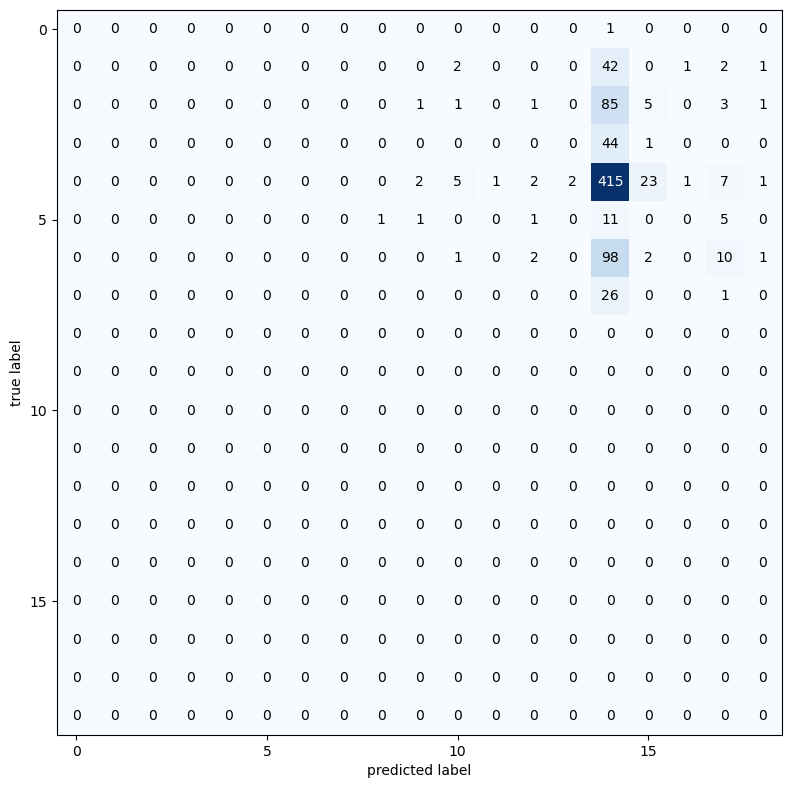

In [45]:
width_shape=300
height_shape=300
names=['CLASS_01','CLASS_02','CLASS_03','CLASS_04','CLASS_05','CLASS_06','CLASS_07','CLASS_08']
test_data_dir = 'C:\\Users\\henry\\Downloads\\data\\test'
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape,height_shape),
    class_mode='categorical',
    shuffle=False)
modelo=load_model("C:\\Users\\henry\\modelo.h5py")
predicciones=model.predict(test_generator)
y_pred=np.argmax(predicciones,axis=1)
y_real=test_generator.classes

matc=confusion_matrix(y_real,y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(8,8),show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred,digits=4))